In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations

df = pd.read_csv("indian_food.csv")

# Since I need to do some ingredient based analysis later on I created the ingredient_list column with ingredients in list form
df['ingredient_list'] = df['ingredients'].apply(lambda x:[i.strip().lower() for i in str(x).split(',')])

# We will check the dataframe first
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             255 non-null    object
 1   ingredients      255 non-null    object
 2   diet             255 non-null    object
 3   prep_time        255 non-null    int64 
 4   cook_time        255 non-null    int64 
 5   flavor_profile   255 non-null    object
 6   course           255 non-null    object
 7   state            255 non-null    object
 8   region           254 non-null    object
 9   ingredient_list  255 non-null    object
dtypes: int64(2), object(8)
memory usage: 20.1+ KB


In [2]:
# These are all not null but we can see some NaN values have been marked as -1 which is not good for the questions I am asking
# We replace them with "Unknown"

df['state'] = df['state'].replace('-1','Unknown')
df['region'] = df['region'].replace('-1','Unknown')

# Get the value counts
print(df['state'].value_counts())
print()
print(df['region'].value_counts())

state
Gujarat            35
Punjab             32
Maharashtra        30
Unknown            24
West Bengal        24
Assam              21
Tamil Nadu         20
Andhra Pradesh     10
Uttar Pradesh       9
Kerala              8
Odisha              7
Karnataka           6
Rajasthan           6
Telangana           5
Bihar               3
Goa                 3
Madhya Pradesh      2
Jammu & Kashmir     2
Manipur             2
Uttarakhand         1
Tripura             1
NCT of Delhi        1
Nagaland            1
Haryana             1
Chhattisgarh        1
Name: count, dtype: int64

region
West          74
South         59
North         49
East          31
North East    25
Unknown       13
Central        3
Name: count, dtype: int64


In [4]:
# Well there are 13 unknown regions, I think we can put the region names where the state is populated
df[((df['state'] != 'Unknown') & (df['region'] == 'Unknown'))]
# By this we know there aren't any values where region is Unknown and state is populated. 

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region,ingredient_list


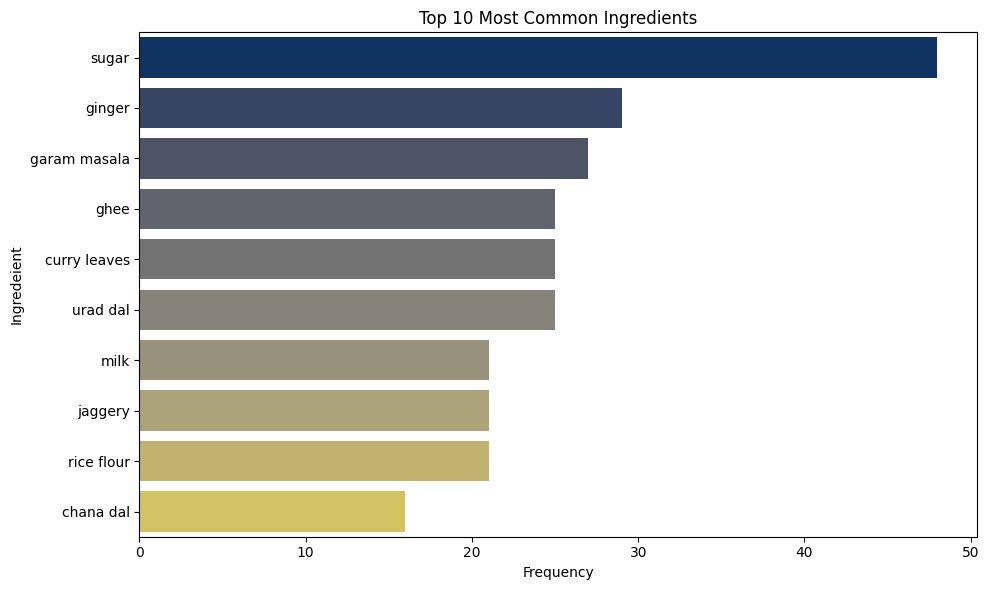

In [6]:
# Let us begin with a simple plot of the most common ingredients.
all_ingredients = sum(df['ingredient_list'],[]) # consolidates the entire list of ingredients into one giant list
ingredient_counts = Counter(all_ingredients)

# Show top 10 most common ingredients
top_10_ingredient_counts = ingredient_counts.most_common(10)
# Create the dataframe out of it
top10df = pd.DataFrame(top_10_ingredient_counts, columns=['Ingredient','Count'])

# Plot the graph
plt.figure(figsize=(10,6))
sns.barplot(data=top10df,x='Count',y='Ingredient',palette='cividis', hue='Ingredient', legend=False)
plt.title('Top 10 Most Common Ingredients')
plt.xlabel('Frequency')
plt.ylabel('Ingredeient')b
plt.tight_layout()
plt.show()


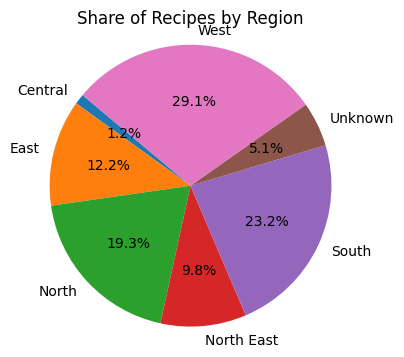

In [14]:
# Next, let us look at how the recipes are distributed across the regions. A small plot will do.
region_wise_df = df.groupby('region').size().reset_index(name='count')
# Plot the graph
plt.figure(figsize=(4,4))
plt.pie(region_wise_df['count'], labels=region_wise_df['region'], autopct='%1.1f%%', startangle=140)
plt.title('Share of Recipes by Region')
plt.axis('equal')  # Keeps pie chart circular
plt.show()

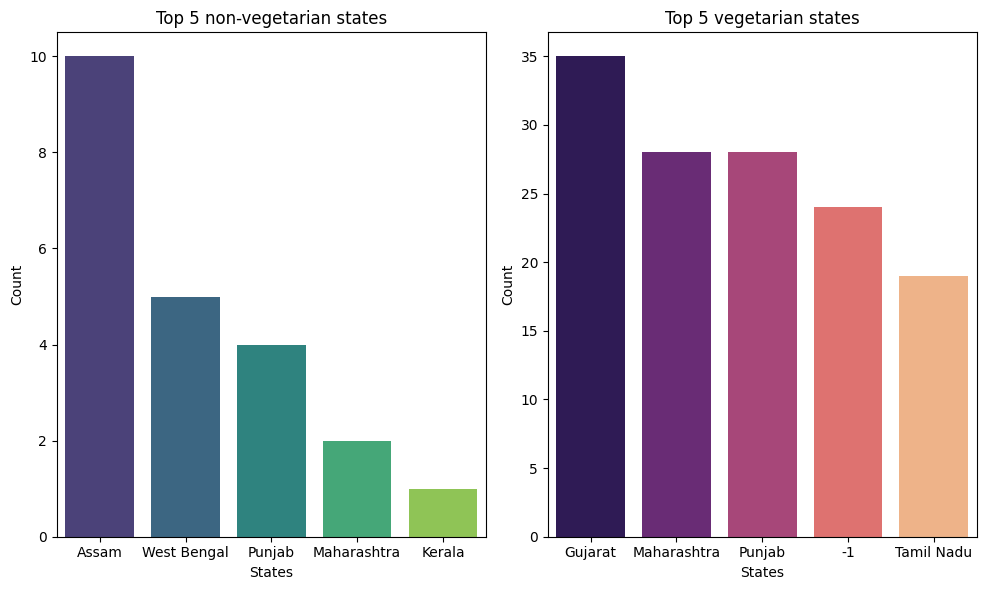

In [2]:
# From this we can determine that the data of West, North and South regions can be compared. For region-wise analysis I will be 
# focusing on these regions
# Let us plot top vegetarian as well as non-vegetarian states

nonvegetarian = df[df['diet'] != 'vegetarian']
vegetarian = df[df['diet'] == 'vegetarian']

# Step 2: Group by state and count (or do any aggregation)
grouped_nonveg = nonvegetarian.groupby('state').size().reset_index(name='count')
grouped_veg = vegetarian.groupby('state').size().reset_index(name='count')

# Ok so it seems that we have 30 states with non-veg dishes. Can't plot that many on a graph, so we will plot only 5. I'll first sort them
# Now I am sure there is an easier way but bear with me, this is my first one
grouped_nonveg = grouped_nonveg.sort_values(by='count',ascending=False)
grouped_veg = grouped_veg.sort_values(by='count',ascending=False)

# Plot it now
non_veg_top5 = grouped_nonveg.head(5)
veg_top5 = grouped_veg.head(5)

# Create a figure and axes (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plotting on the first subplot
sns.barplot(x='state',y='count',data=non_veg_top5, ax=ax1, palette='viridis',hue='state')
ax1.set_title('Top 5 non-vegetarian states')
ax1.set_xlabel('States')
ax1.set_ylabel('Count')
# ax1.legend()

# Plotting on the second subplot
sns.barplot(x='state',y='count',data=veg_top5, ax=ax2,palette='magma',hue='state')
ax2.set_title('Top 5 vegetarian states')
ax2.set_xlabel('States')
ax2.set_ylabel('Count')
# ax2.legend()

# Show the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Excluding 30 recipes with missing prep times and 28 with missing cook times from plot



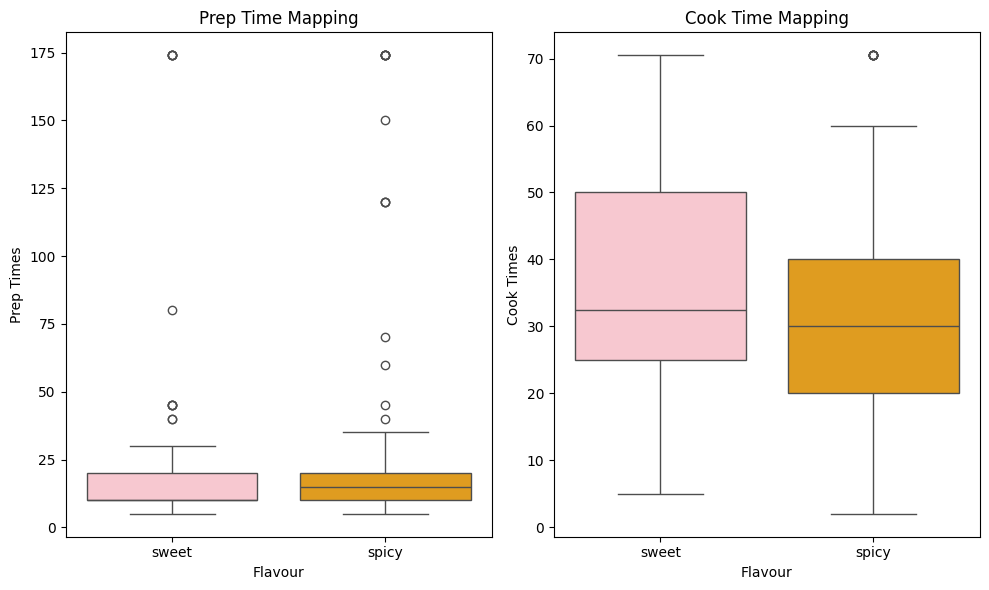

In [3]:
df['prep_time'] = df['prep_time'].replace(-1,np.nan)
df['cook_time'] = df['cook_time'].replace(-1,np.nan)

# Trying to remove principal outliers
upper_limit1 = df['prep_time'].quantile(0.95)
upper_limit2 = df['cook_time'].quantile(0.95)

df['prep_time'] = np.where(df['prep_time'] > upper_limit1, upper_limit1, df['prep_time'])
df['cook_time'] = np.where(df['cook_time'] > upper_limit2, upper_limit2, df['cook_time'])

num_missing1 = df['prep_time'].isna().sum()
num_missing2 = df['cook_time'].isna().sum()

print(f"Excluding {num_missing1} recipes with missing prep times and {num_missing2} with missing cook times from plot")
print()
plot_df1 = df[df['prep_time'].notna() & df['flavor_profile'].isin (['sweet','spicy']) ]
plot_df2 = df[df['cook_time'].notna() & df['flavor_profile'].isin (['sweet','spicy']) ]

# Create a figure and axes (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plotting on the first subplot
sns.boxplot(data=plot_df1, x='flavor_profile', y='prep_time', hue = 'flavor_profile' , palette={'sweet': 'pink', 'spicy': 'orange'}, ax=ax1)
ax1.set_title('Prep Time Mapping')
ax1.set_xlabel('Flavour')
ax1.set_ylabel('Prep Times')
# ax1.legend()

# Plotting on the second subplot
sns.boxplot(data=plot_df2, x='flavor_profile', y='cook_time', hue = 'flavor_profile', palette={'sweet': 'pink', 'spicy': 'orange'}, ax=ax2)
ax2.set_title('Cook Time Mapping')
ax2.set_xlabel('Flavour')
ax2.set_ylabel('Cook Times')
# ax2.legend()

# Show the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()


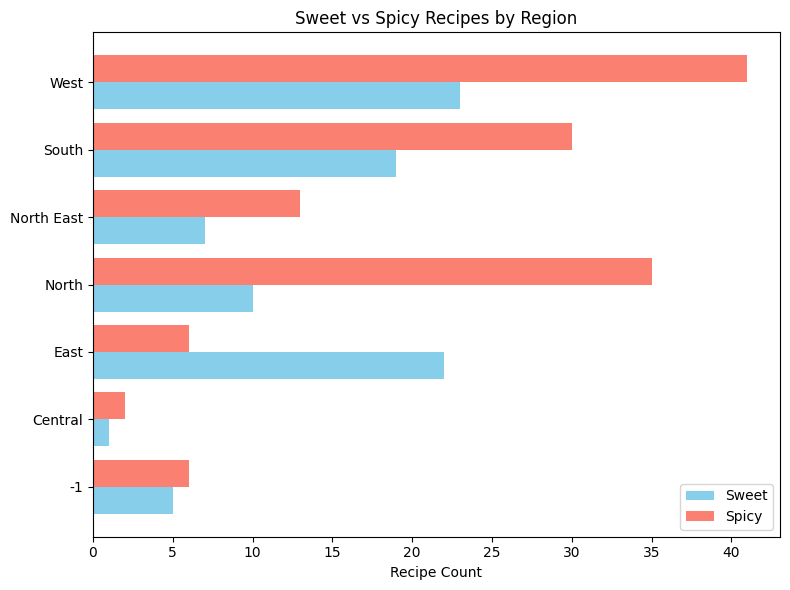

In [4]:
# Q. How many sweet and spciy recipes are there per region

flavour_counts = df.groupby(['region', 'flavor_profile']).size().unstack(fill_value=0)

# Regions for Y-axis
regions = flavour_counts.index.tolist()
# Bar positions
y = np.arange(len(regions))
bar_height = 0.4

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(y - bar_height/2, flavour_counts['sweet'], height=bar_height, label='Sweet', color='skyblue')
ax.barh(y + bar_height/2, flavour_counts['spicy'], height=bar_height, label='Spicy', color='salmon')

# Labels and formatting
ax.set_yticks(y)
ax.set_yticklabels(regions)
ax.set_xlabel('Recipe Count')
ax.set_title('Sweet vs Spicy Recipes by Region')
ax.legend()
plt.tight_layout()
plt.show()